<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [1]:
import numpy as np
import time
import sys
import os
import pandas as pd
import seaborn as sns
from functools import reduce
from operator import itemgetter
import itertools
import re
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.pyplot import cm
from fuzzywuzzy import fuzz 
from fuzzywuzzy import process
from scipy import signal
from scipy.stats import gaussian_kde

In [2]:
sns.set_style('whitegrid')

In [31]:
df = pd.read_csv('NBA_Full_Matchup_Data.csv', index_col=0)
dfp = pd.read_csv('CompleteNBAPlayerLineupStats.csv')
dfl = pd.read_csv('NBALineupStats.csv', index_col=0)

#dfp = dfp[dfp.year == 2017]
#dfl = dfl[dfl.year == 2017]


In [32]:
dfp['home_code'] = dfp['sorted_code']
dfp['vis_code'] = dfp['sorted_code']

dfl['home_code'] = dfl['sorted_code']
dfl['vis_code'] = dfl['sorted_code']

new_home_codes = []
new_away_codes = []
for index, matchup in df.iterrows():
    home_code_arr = [x.split(' ')[0][0]+''.join(x.split(' ')[1:]) for x in sorted(matchup.ht_lineup.split(','))]
    home_code_str = ''.join(home_code_arr).replace('.', '').replace('\'', '')
    away_code_arr = [x.split(' ')[0][0]+''.join(x.split(' ')[1:]) for x in sorted(matchup.vt_lineup.split(','))]
    away_code_str = ''.join(away_code_arr).replace('.', '').replace('\'', '')
    new_home_codes.append(home_code_str + matchup.home_team + str(int(matchup.year)))
    new_away_codes.append(away_code_str + matchup.vis_team + str(int(matchup.year)))
df['home_code'] = new_home_codes
df['vis_code'] = new_away_codes
df


,year,game,home_team,vis_team,Q,time_sec,ht_score,vt_score,ht_margin,vt_margin,...,vt_3PTM,ht_stint_pm,vt_stint_pm,ht_stint_poss,vt_stint_poss,total_poss,ht_pm_ph,vt_pm_ph,home_code,vis_code
0,2017,1,CLE,NYK,1,395.0,14,12,2,-2,...,1,2,-2,63,63,99,3.174603,-3.174603,JSmithKLoveKIrvingLJamesTThompsonCLE2017,CAnthonyCLeeDRoseJNoahKPorzingisNYK2017
1,2017,1,CLE,NYK,1,455.0,15,12,3,-3,...,1,1,-1,12,12,12,8.333333,-8.333333,JSmithKIrvingLJamesRJeffersonTThompsonCLE2017,BJenningsCAnthonyCLeeKPorzingisKOQuinnNYK2017
2,2017,1,CLE,NYK,1,536.0,19,16,3,-3,...,1,0,0,11,11,11,0.000000,0.000000,IShumpertKIrvingLJamesRJeffersonTThompsonCLE2017,BJenningsCAnthonyCLeeKOQuinnLThomasNYK2017
3,2017,1,CLE,NYK,1,620.0,23,16,7,-7,...,1,4,-4,14,14,14,28.571429,-28.571429,IShumpertKLoveMDunleavyRJeffersonTThompsonCLE2017,BJenningsCAnthonyCLeeKOQuinnLThomasNYK2017
4,2017,1,CLE,NYK,1,632.0,23,16,7,-7,...,1,0,0,4,4,4,0.000000,0.000000,IShumpertKLoveMDunleavyRJeffersonTThompsonCLE2017,BJenningsCLeeJHolidayKOQuinnLThomasNYK2017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
162353,2019,1230,POR,SAC,4,2371.0,111,117,-6,6,...,17,7,-7,17,17,17,41.176471,-41.176471,ASimonsGTrentJrJLaymanMLeonardZCollinsPOR2019,BBogdanovicCBrewerFMasonMBagleyIIITWilliamsSAC...
162354,2019,1230,POR,SAC,4,2407.0,116,117,-1,1,...,17,5,-5,6,6,6,83.333333,-83.333333,ASimonsGTrentJrJLaymanMLeonardSLabissierePOR2019,BBogdanovicCBrewerFMasonMBagleyIIITWilliamsSAC...
162355,2019,1230,POR,SAC,4,2517.0,120,117,3,-3,...,17,4,-4,18,18,18,22.222222,-22.222222,ASimonsGTrentJrJLaymanMLeonardSLabissierePOR2019,BBogdanovicCBrewerFMasonMBagleyIIIYFerrellSAC2019
162356,2019,1230,POR,SAC,4,2579.0,122,117,5,-5,...,17,2,-2,7,7,7,28.571429,-28.571429,ASimonsGTrentJrJLaymanMLeonardSLabissierePOR2019,BJohnsonCBrewerFMasonMBagleyIIIYFerrellSAC2019


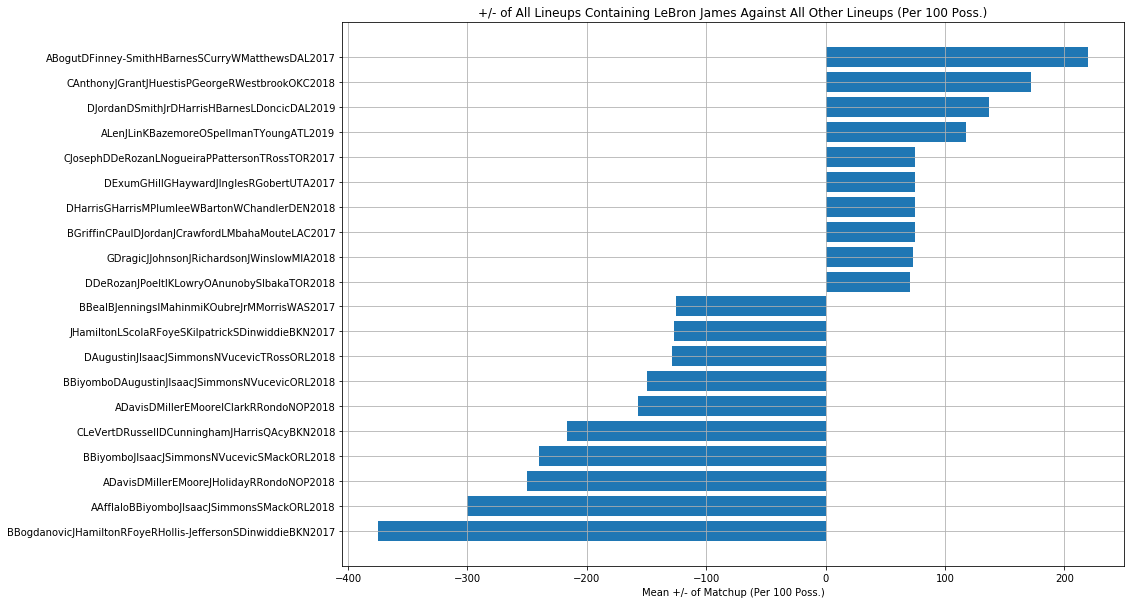

In [16]:
#plt.figure(figsize=(14, 84))
plt.figure(figsize=(14, 10))
plt.title('+/- of All Lineups Containing LeBron James Against All Other Lineups (Per 100 Poss.)')
plt.xlabel('Mean +/- of Matchup (Per 100 Poss.)')

#df_cle = (df[df.home_code == 'JSmithKLoveKIrvingLJamesTThompsonCLE2017']).groupby(['vis_code'], as_index=False).mean()
df_cle = (df[df.home_code.str.contains('LJames')]).groupby(['vis_code'], as_index=False).mean()

#mask = np.column_stack([df[col].str.contains('JSmithKLoveKIrvingLJamesTThompsonCLE2017') for col in df if col == 'home_code' or col == 'vis_code'])
#df_cle = df.loc[mask.any(axis=1)]

df_sort = df_cle.sort_values('ht_pm_ph')
plt.barh(df_sort.vis_code.values[np.r_[0:10,-11:-1]], df_sort.ht_pm_ph.values[np.r_[0:10,-11:-1]])

plt.grid()


In [17]:
dflh = dfl.copy()
#cols = dflh.columns[dflh.columns.str.contains('code') == False]
dflh.columns = dflh.columns.map(lambda x: str(x) + '_h')
#print(dflh.columns)
dflv = dfl.copy()
dflv.columns = dflv.columns.map(lambda x: str(x) + '_v')
#print(dflv.columns)

dfm = pd.merge(df, dflh, how='inner', left_on=['home_code'], right_on=['home_code_h'])
#print(dfm.vis_code)
dfm = pd.merge(dfm, dflv, how='inner', left_on=['vis_code'], right_on=['vis_code_v'])

numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
dfmm = dfm.select_dtypes(include=numerics).filter(like='_h') - dfm.select_dtypes(include=numerics).filter(like='_v').values
dfmm.columns = dfmm.columns.str.rstrip('_h')
dfmm.columns = dfmm.columns.map(lambda x: str(x) + '_rel')
dfmm = dfmm.drop(columns=['year_rel'])
dfm = dfm.join(dfmm)
dfm


,year,game,home_team,vis_team,Q,time_sec,ht_score,vt_score,ht_margin,vt_margin,...,EFGPT_rel,TST_rel,PACET_rel,PIET_rel,2PAT_PT_rel,2PMT_PT_rel,2PPT_PT_rel,2PAT_PH_rel,2PMT_PH_rel,2PPT_PH_rel
0,2017,47,CLE,HOU,3,1858.0,78,74,4,-4,...,12.2,14.6,4.42,0.3,3.7,6.3,0.113253,3.6,7.5,0.111179
1,2017,114,SAS,HOU,2,1009.0,37,43,-6,6,...,38.4,36.9,-6.79,24.7,-23.7,-1.8,0.580677,-30.0,-1.4,0.572000
2,2017,999,CLE,DET,3,1943.0,95,62,33,-33,...,15.1,20.8,-8.98,15.9,-5.5,-2.7,0.005670,-2.0,-0.7,0.006805
3,2017,498,ATL,DET,1,720.0,19,19,0,0,...,2.1,4.8,-13.08,-13.2,-13.3,-11.1,-0.117969,-9.4,-10.4,-0.116790
4,2017,498,ATL,DET,1,628.0,17,13,4,-4,...,19.5,20.6,3.69,14.2,-0.9,-1.1,-0.013380,-4.6,-3.0,-0.010805
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55592,2019,1226,MIL,OKC,4,2880.0,116,127,-11,11,...,50.0,69.1,34.33,100.0,25.0,8.4,0.336000,30.0,10.0,0.333333
55593,2019,1230,POR,SAC,3,1804.0,79,100,-21,21,...,50.8,53.4,-10.50,97.5,-1.2,28.0,0.626398,8.9,37.0,0.628183
55594,2019,1230,POR,SAC,3,2044.0,91,110,-19,19,...,5.0,6.1,15.80,12.0,8.7,10.0,0.126398,1.7,8.5,0.129932
55595,2019,1230,POR,SAC,4,2517.0,120,117,3,-3,...,67.5,68.6,-18.02,230.1,25.0,28.0,0.626398,38.9,37.0,0.628183


(48, -0.5)

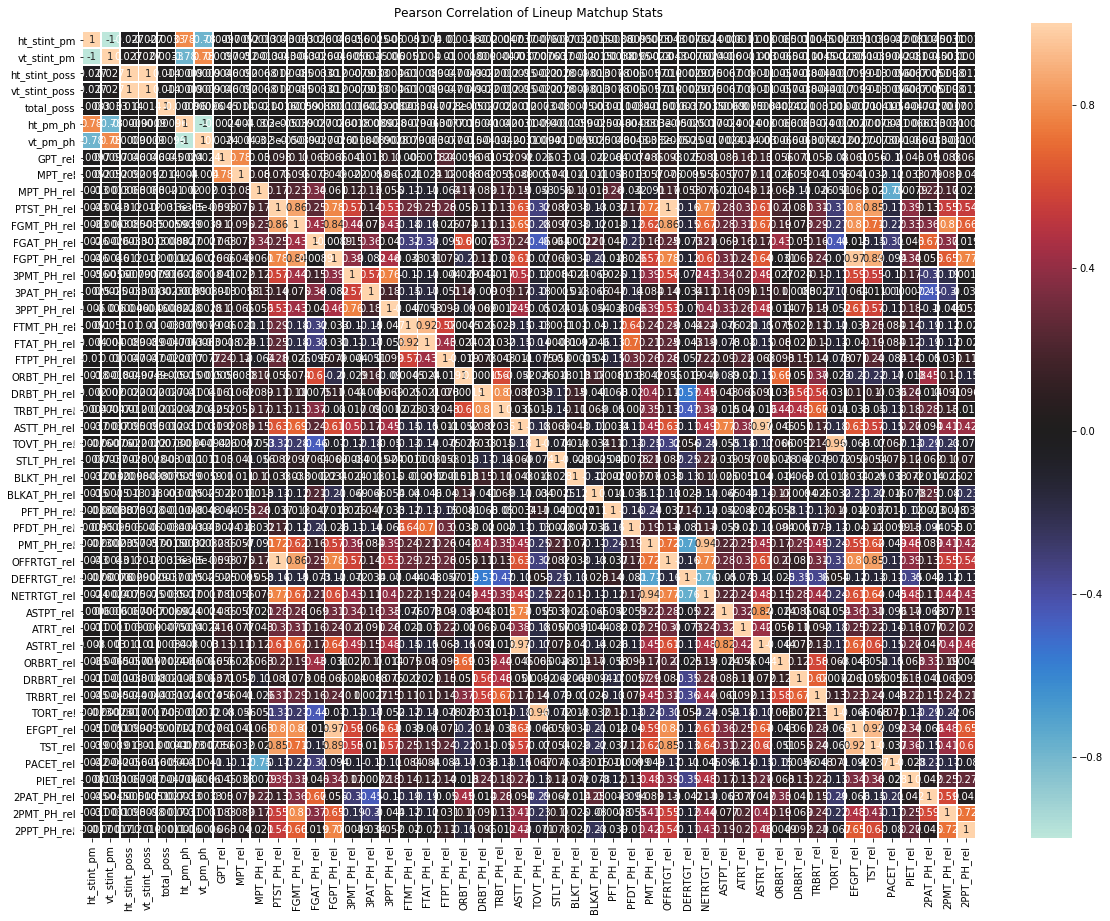

In [20]:
fig, ax = plt.subplots(figsize=(20, 15))
#cols_to_inc = ['']
dff = dfm.select_dtypes(include=numerics)
dff = dff[dff.columns[dff.columns.str.contains('_h') == False]]
dff = dff[dff.columns[dff.columns.str.contains('_v') == False]]
dff = dff[dff.columns[dff.columns.str.contains('game') == False]]
dff = dff[dff.columns[dff.columns.str.contains('Q') == False]]
dff = dff[dff.columns[dff.columns.str.contains('time_sec') == False]]
dff = dff[dff.columns[dff.columns.str.contains('score') == False]]
dff = dff[dff.columns[dff.columns.str.contains('margin') == False]]
dff = dff[dff.columns[dff.columns.str.contains('year') == False]]
dff = dff[dff.columns[dff.columns.str.contains('time') == False]]
dff = dff[dff.columns[dff.columns.str.contains('fouls') == False]]
dff = dff[dff.columns[dff.columns.str.contains('technicals') == False]]
dff = dff[dff.columns[dff.columns.str.contains('flagrants') == False]]
dff = dff[dff.columns[dff.columns.str.contains('_2PT') == False]]
dff = dff[dff.columns[dff.columns.str.contains('_3PT') == False]]
dff = dff[dff.columns[dff.columns.str.contains('_PT_') == False]]
features = dff
pc = features.corr(method='pearson')
sns.heatmap(pc, annot=True, xticklabels=pc.columns, 
            yticklabels=pc.columns, ax=ax, linewidths=.5, 
            vmin = -1, vmax=1, center=0)
plt.title("Pearson Correlation of Lineup Matchup Stats")
ax.set_ylim(len(pc), -0.5)


TypeError: cannot unpack non-iterable Figure object

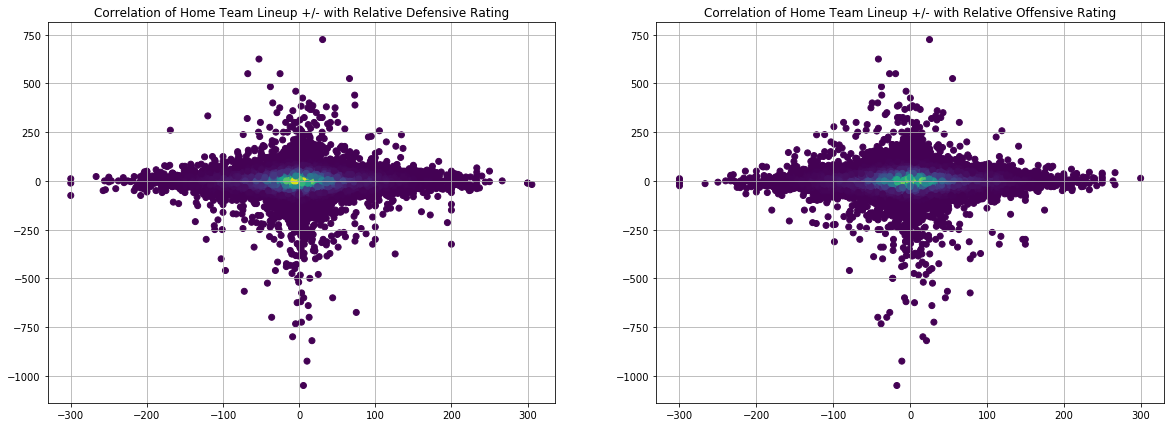

<Figure size 720x504 with 0 Axes>

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(20, 7))

plt.axes(ax[0])
plt.title('Correlation of Home Team Lineup +/- with Relative Defensive Rating')
xy = np.vstack([-dfm.DEFRTGT_rel.values, dfm.ht_pm_ph.values])
z = gaussian_kde(xy)(xy)
plt.scatter(-dfm.DEFRTGT_rel, dfm.ht_pm_ph, c=z)
plt.grid()

plt.axes(ax[1])
plt.title('Correlation of Home Team Lineup +/- with Relative Offensive Rating')
xy = np.vstack([dfm.OFFRTGT_rel.values, dfm.ht_pm_ph.values])
z = gaussian_kde(xy)(xy)
plt.scatter(dfm.OFFRTGT_rel, dfm.ht_pm_ph, c=z)
plt.grid()


fig, ax = plt.figure(figsize=(10, 7))
plt.title('Correlation of Home Team Lineup +/- with Relative Offensive Rating')
xy = np.vstack([dfm.NETRTGT_rel.values, dfm.ht_pm_ph.values])
z = gaussian_kde(xy)(xy)
plt.scatter(dfm.NETRTGT_rel, dfm.ht_pm_ph, c=z)
plt.grid()


In [24]:
#dfmc = dfm[dfm.NETRTGT_h-dfm.NETRTGT_v < 0]
#dfmc = dfmc[dfmc.ht_pm_ph > 0]
#dfmc = dfmc[dfmc.total_poss > 10]
dfmc = dfm[dfm.ht_pm_ph > 0]
print(dfmc)


       year  game home_team vis_team  Q  time_sec  ht_score  vt_score  \
3      2017   498       ATL      DET  1     720.0        19        19   
5      2017   498       ATL      DET  1     628.0        17        13   
8      2017   999       CLE      DET  3    2159.0       104        70   
15     2017   772       ATL      UTA  3    2023.0        68        82   
29     2017  1032       CHI      UTA  1     616.0        12        20   
...     ...   ...       ...      ... ..       ...       ...       ...   
55588  2019  1225       MEM      GSW  1     720.0        45        41   
55590  2019  1226       MIL      OKC  1     716.0        29        29   
55594  2019  1230       POR      SAC  3    2044.0        91       110   
55595  2019  1230       POR      SAC  4    2517.0       120       117   
55596  2019  1230       POR      SAC  4    2579.0       122       117   

       ht_margin  vt_margin  ... EFGPT_rel TST_rel  PACET_rel  PIET_rel  \
3              0          0  ...       2.1     4

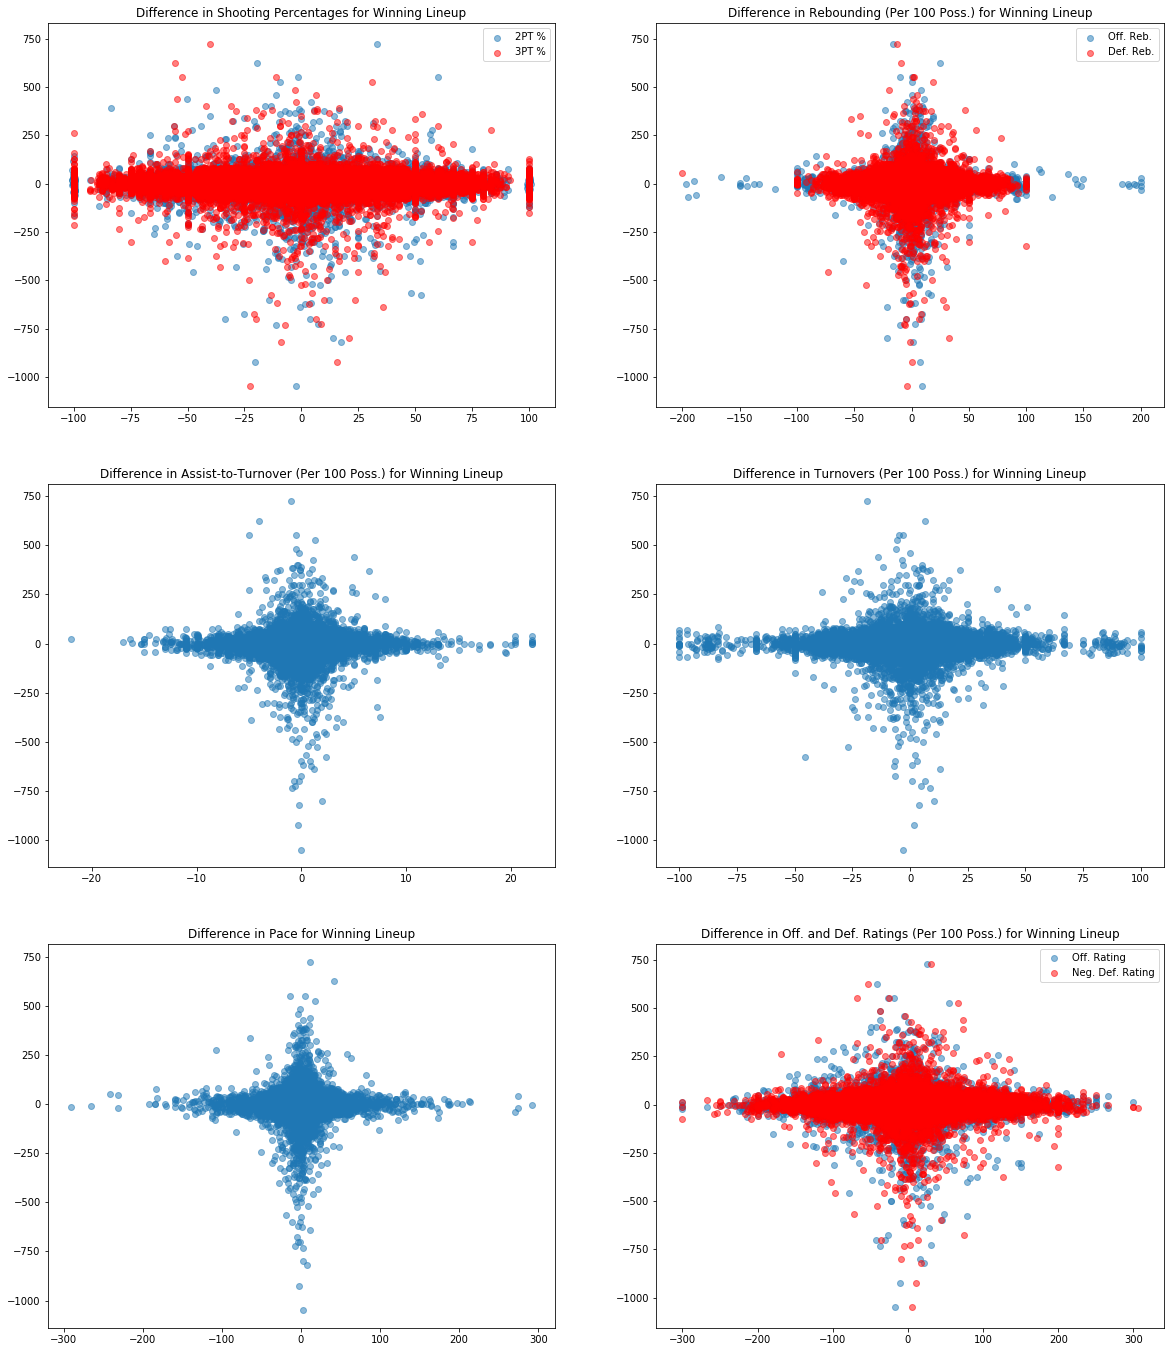

In [25]:
fig, ax = plt.subplots(3, 2, figsize=(20, 24))

plt.axes(ax[0,0])
plt.title('Difference in Shooting Percentages for Winning Lineup')
avg_2PP = np.mean(dfm['2PPT_PH_rel']*100.)
plt.scatter((dfm['2PPT_PH_rel'])*100., dfm.ht_pm_ph, alpha=0.5, label='2PT %')
#plt.axvline(avg_2PP, linestyle='--', color='b')
avg_3PP = np.mean(dfm['3PPT_PH_rel'])
plt.scatter(dfm['3PPT_PH_rel'], dfm.ht_pm_ph, alpha=0.5, color='r', label='3PT %')
#plt.axvline(avg_3PP, linestyle='--', color='r')
plt.legend()

plt.axes(ax[0,1])
plt.title('Difference in Rebounding (Per 100 Poss.) for Winning Lineup')
avg_ORBT = np.mean(dfm['ORBT_PH_rel'])
plt.scatter(dfm['ORBT_PH_rel'], dfm.ht_pm_ph, alpha=0.5, label='Off. Reb.')
#plt.axvline(avg_ORBT, linestyle='--', color='b')
avg_DRBT = np.mean(dfm['DRBT_PH_rel'])
plt.scatter(dfm['DRBT_PH_rel'], dfm.ht_pm_ph, alpha=0.5, color='r', label='Def. Reb.')
#plt.axvline(avg_DRBT, linestyle='--', color='r')
plt.legend()

plt.axes(ax[1,0])
plt.title('Difference in Assist-to-Turnover (Per 100 Poss.) for Winning Lineup')
avg_ATRT = np.mean(dfm['ATRT_rel'])
plt.scatter(dfm['ATRT_rel'], dfm.ht_pm_ph, alpha=0.5)
#plt.axvline(avg_ATRT, linestyle='--', color='b')

plt.axes(ax[1,1])
plt.title('Difference in Turnovers (Per 100 Poss.) for Winning Lineup')
avg_TOVT = np.mean(dfm['TOVT_PH_rel'])
plt.scatter(dfm['TOVT_PH_rel'], dfm.ht_pm_ph, alpha=0.5)
#plt.axvline(avg_TOVT, linestyle='--', color='b')

plt.axes(ax[2,0])
plt.title('Difference in Pace for Winning Lineup')
avg_PACET = np.mean(dfm['PACET_rel'])
plt.scatter(dfm['PACET_rel'], dfm.ht_pm_ph, alpha=0.5)
#plt.axvline(avg_PACET, linestyle='--', color='b')

plt.axes(ax[2,1])
plt.title('Difference in Off. and Def. Ratings (Per 100 Poss.) for Winning Lineup')
avg_OFFRTGT = np.mean(dfm['OFFRTGT_rel'])
plt.scatter(dfm['OFFRTGT_rel'], dfm.ht_pm_ph, alpha=0.5, label='Off. Rating')
#plt.axvline(avg_OFFRTGT, linestyle='--', color='b')
avg_DEFRTGT = -np.mean(dfm['DEFRTGT_rel'])
plt.scatter(-dfm['DEFRTGT_rel'], dfm.ht_pm_ph, alpha=0.5, color='r', label='Neg. Def. Rating')
#plt.axvline(avg_DEFRTGT, linestyle='--', color='r')
plt.legend()


In [7]:
#jp = sns.jointplot(x="TOVT_PH_rel", y="ht_pm_ph", data=dfm, height=8, marker='.').plot_joint(sns.kdeplot, n_levels=10).set_axis_labels('Turnovers (Per 100 Poss.)', '+/- Per 100 Poss.')


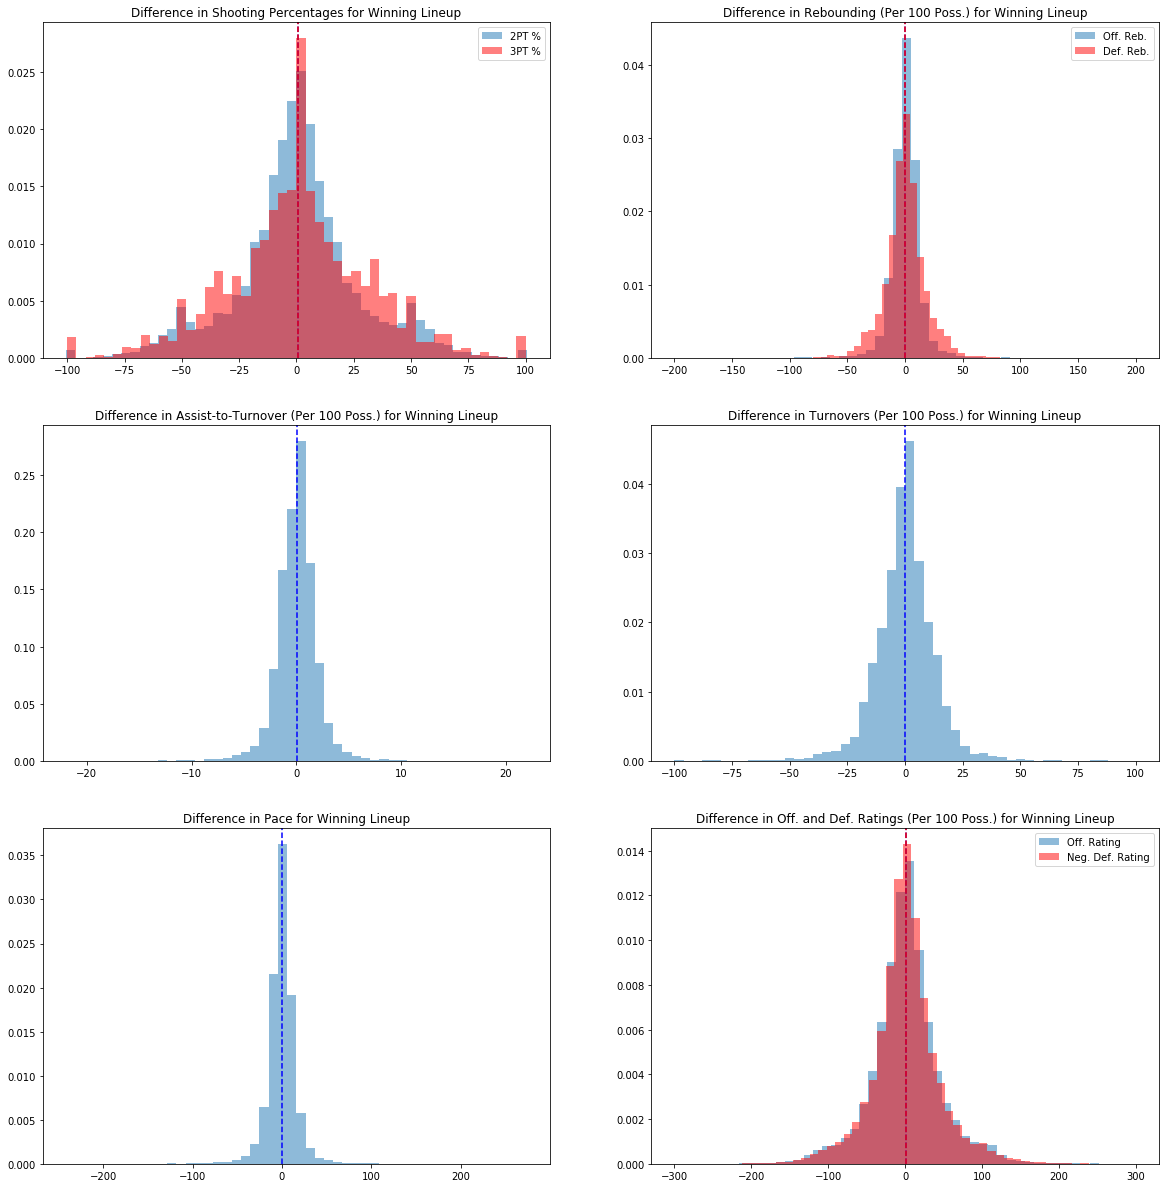

In [27]:
fig, ax = plt.subplots(3, 2, figsize=(20, 21))

plt.axes(ax[0,0])
plt.title('Difference in Shooting Percentages for Winning Lineup')
avg_2PP = np.mean(dfmc['2PPT_PH_rel']*100.)
plt.hist((dfmc['2PPT_PH_rel'])*100., bins=50, density=True, alpha=0.5, label='2PT %')
plt.axvline(avg_2PP, linestyle='--', color='b')
avg_3PP = np.mean(dfmc['3PPT_PH_rel'])
plt.hist(dfmc['3PPT_PH_rel'], bins=50, density=True, alpha=0.5, color='r', label='3PT %')
plt.axvline(avg_3PP, linestyle='--', color='r')
#plt.yscale('log')
plt.legend()

plt.axes(ax[0,1])
plt.title('Difference in Rebounding (Per 100 Poss.) for Winning Lineup')
avg_ORBT = np.mean(dfmc['ORBT_PH_rel'])
plt.hist(dfmc['ORBT_PH_rel'], bins=50, density=True, alpha=0.5, label='Off. Reb.')
plt.axvline(avg_ORBT, linestyle='--', color='b')
avg_DRBT = np.mean(dfmc['DRBT_PH_rel'])
plt.hist(dfmc['DRBT_PH_rel'], bins=50, density=True, alpha=0.5, color='r', label='Def. Reb.')
plt.axvline(avg_DRBT, linestyle='--', color='r')
plt.legend()

plt.axes(ax[1,0])
plt.title('Difference in Assist-to-Turnover (Per 100 Poss.) for Winning Lineup')
avg_ATRT = np.mean(dfmc['ATRT_rel'])
plt.hist(dfmc['ATRT_rel'], bins=50, density=True, alpha=0.5)
plt.axvline(avg_ATRT, linestyle='--', color='b')

plt.axes(ax[1,1])
plt.title('Difference in Turnovers (Per 100 Poss.) for Winning Lineup')
avg_TOVT = np.mean(dfmc['TOVT_PH_rel'])
plt.hist(dfmc['TOVT_PH_rel'], bins=50, density=True, alpha=0.5)
plt.axvline(avg_TOVT, linestyle='--', color='b')

plt.axes(ax[2,0])
plt.title('Difference in Pace for Winning Lineup')
avg_PACET = np.mean(dfmc['PACET_rel'])
plt.hist(dfmc['PACET_rel'], bins=50, density=True, alpha=0.5)
plt.axvline(avg_PACET, linestyle='--', color='b')

plt.axes(ax[2,1])
plt.title('Difference in Off. and Def. Ratings (Per 100 Poss.) for Winning Lineup')
avg_OFFRTGT = np.mean(dfmc['OFFRTGT_rel'])
plt.hist(dfmc['OFFRTGT_rel'], bins=50, density=True, alpha=0.5, label='Off. Rating')
plt.axvline(avg_OFFRTGT, linestyle='--', color='b')
avg_DEFRTGT = -np.mean(dfmc['DEFRTGT_rel'])
plt.hist(-dfmc['DEFRTGT_rel'], bins=50, density=True, alpha=0.5, color='r', label='Neg. Def. Rating')
plt.axvline(avg_DEFRTGT, linestyle='--', color='r')
plt.legend()


In [1]:
dfph = dfp.copy()
dfph.columns = dfph.columns.map(lambda x: str(x) + '_h')
dfpv = dfp.copy()
dfpv.columns = dfpv.columns.map(lambda x: str(x) + '_v')

dfmp = pd.merge(df, dfph, how='inner', left_on=['home_code'], right_on=['home_code_h'])
dfmp = pd.merge(dfmp, dfpv, how='inner', left_on=['vis_code'], right_on=['vis_code_v'])

numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
dfmpm = dfmp.select_dtypes(include=numerics).filter(like='_h') - dfmp.select_dtypes(include=numerics).filter(like='_v').values
dfmpm.columns = dfmpm.columns.str.rstrip('_h')
dfmpm.columns = dfmpm.columns.map(lambda x: str(x) + '_rel')
dfmpm = dfmpm.drop(columns=['year_rel'])

dfmp = dfmp.join(dfmpm)
#dfmp
#dfmp.groupby(['home_code', 'vis_code'], as_index=False)['name_h'].transform('count')%5 != 0
dfmp_missing = dfmp.iloc[dfmp.groupby(['home_code', 'vis_code'], as_index=False)['name_h'].transform('count').values[:,0]%5 != 0,:]
dfmp = dfmp.iloc[dfmp.groupby(['home_code', 'vis_code'], as_index=False)['name_h'].transform('count').values[:,0]%5 == 0,:]
dfmp


NameError: name 'dfp' is not defined

In [451]:
#dfmpa = dfmp.groupby(['home_code', 'vis_code', 'name_h', 'name_v'], as_index=False).mean()
#dfmpa[dfmpa.name_h=='Alex Abrines']
dfmpa = dfmp.groupby(['home_code', 'vis_code', 'name_h', 'name_v'], as_index=False).mean()
#dfmpa.groupby(['home_code', 'vis_code', 'name_h'], as_index=False)['name_v'].count()
#dfmpa[dfmpa.name_h.str.contains('Gibson')]
dfp[dfp.name.str.contains('Gibson')]

,name,pos,team,year,GP,GS,age,W,L,WLR,...,PIET,2PAT_PT,2PMT_PT,2PPT_PT,2PAT_PH,2PMT_PH,2PPT_PH,sorted_code,home_code,vis_code
4918,Taj Gibson,PF,TOT,2017,78.0,71.0,32.0,41.0,37.0,1.108108,...,51.4,59.1,28.7,0.485618,81.6,39.7,0.486520,DWadeJButlerRLopezRRondoTGibsonTOT2017,DWadeJButlerRLopezRRondoTGibsonTOT2017,DWadeJButlerRLopezRRondoTGibsonTOT2017
4919,Taj Gibson,PF,TOT,2017,78.0,71.0,32.0,41.0,37.0,1.108108,...,46.3,55.8,23.2,0.415771,79.7,33.1,0.415307,DWadeJButlerMCarter-WilliamsRLopezTGibsonTOT2017,DWadeJButlerMCarter-WilliamsRLopezTGibsonTOT2017,DWadeJButlerMCarter-WilliamsRLopezTGibsonTOT2017
4920,Taj Gibson,PF,TOT,2017,78.0,71.0,32.0,41.0,37.0,1.108108,...,42.6,53.2,24.3,0.456767,70.8,32.3,0.456215,DMcDermottJButlerRLopezRRondoTGibsonTOT2017,DMcDermottJButlerRLopezRRondoTGibsonTOT2017,DMcDermottJButlerRLopezRRondoTGibsonTOT2017
4921,Taj Gibson,PF,TOT,2017,78.0,71.0,32.0,41.0,37.0,1.108108,...,52.6,49.3,26.2,0.531440,64.6,34.3,0.530960,DMcDermottJButlerMCarter-WilliamsRLopezTGibson...,DMcDermottJButlerMCarter-WilliamsRLopezTGibson...,DMcDermottJButlerMCarter-WilliamsRLopezTGibson...
4922,Taj Gibson,PF,TOT,2017,78.0,71.0,32.0,41.0,37.0,1.108108,...,47.8,44.8,22.9,0.511161,51.2,26.2,0.511719,DWadeJButlerNMiroticRRondoTGibsonTOT2017,DWadeJButlerNMiroticRRondoTGibsonTOT2017,DWadeJButlerNMiroticRRondoTGibsonTOT2017
4923,Taj Gibson,PF,TOT,2017,78.0,71.0,32.0,41.0,37.0,1.108108,...,52.1,57.6,24.7,0.428819,74.2,31.8,0.428571,ICanaanJButlerRLopezRRondoTGibsonTOT2017,ICanaanJButlerRLopezRRondoTGibsonTOT2017,ICanaanJButlerRLopezRRondoTGibsonTOT2017
4924,Taj Gibson,PF,TOT,2017,78.0,71.0,32.0,41.0,37.0,1.108108,...,57.2,52.2,28.6,0.547893,70.9,38.7,0.545839,ARobersonRWestbrookSAdamsTGibsonVOladipoTOT2017,ARobersonRWestbrookSAdamsTGibsonVOladipoTOT2017,ARobersonRWestbrookSAdamsTGibsonVOladipoTOT2017
4925,Taj Gibson,PF,TOT,2017,78.0,71.0,32.0,41.0,37.0,1.108108,...,48.0,44.0,17.1,0.388636,62.1,24.3,0.391304,DMcDermottRWestbrookSAdamsTGibsonVOladipoTOT2017,DMcDermottRWestbrookSAdamsTGibsonVOladipoTOT2017,DMcDermottRWestbrookSAdamsTGibsonVOladipoTOT2017


In [465]:
dfl[dfl.sorted_code.str.contains('DWadeJButlerRLopezRRondoTGibson')]

,lineup_name,code,year,team,GPT,MPT,PTST_PT,FGMT_PT,FGAT_PT,FGPT_PT,...,PIET,2PAT_PT,2PMT_PT,2PPT_PT,2PAT_PH,2PMT_PH,2PPT_PH,sorted_code,home_code,vis_code
1732,"D Wade, R Rondo, R Lopez, T Gibson, J Butler",DWadeRRondoRLopezTGibsonJButlerCHI2017,2017,CHI,30.0,390.0,77.4,31.6,67.0,47.2,...,51.4,59.1,28.7,0.485618,81.6,39.7,0.48652,DWadeJButlerRLopezRRondoTGibsonCHI2017,DWadeJButlerRLopezRRondoTGibsonCHI2017,DWadeJButlerRLopezRRondoTGibsonCHI2017
